In [254]:
import scipy
from scipy.stats import median_abs_deviation as mad
import numpy as np
from matplotlib import pyplot as plt
import time
from  scipy.io import loadmat as loadmat

In [255]:
rootfolder = '.'
# from google.colab import drive
# drive.mount('/content/drive')

Useful function for the plot

In [256]:
def display_band( X, par,epsi=0.001,col='k'):
    x1 = np.min(X[0, :])
    x2 = np.max(X[0, :])
    y1 = np.min(X[1, :])
    y2 = np.max(X[1, :])

    # extend the line for the k# of its lenght 
    k = 0.01
    dx = x2-x1
    dy = y2-y1
    l = np.sqrt(dx**2+dy**2)
    x1 = x1 - k*l
    x2 = x2 + k*l
    y1 = y1 - k*l
    y2 = y2 + k*l
    ##
    if np.abs(par[1])<2e-2 :
        #disp('vertical line')
        a = np.vstack([-(par[1]*y1 + par[2])/par[0], y1])
        b = np.vstack([-(par[1]*y2 + par[2])/par[0], y2])
    else:
        a = np.vstack([x1, -(par[0]*x1 + par[2])/par[1]])
        b = np.vstack([x2, -(par[0]*x2 + par[2])/par[1]])

    if np.abs(par[0])<1e-5:
        v = np.array([0,1]) 
    else:    
        v = np.array([1, par[1]/par[0]])# direction perpendicular to the line;

    v = v / np.sqrt(np.sum(v**2))
    # corners of the bands
    v = v[:, np.newaxis]
    a1 = a - epsi * v
    a2 = a + epsi * v
    b1 = b - epsi * v
    b2 = b + epsi * v

    px = np.array([a1[0], b1[0], b2[0], a2[0]]).squeeze()
    py = np.array([a1[1], b1[1], b2[1], a2[1]]).squeeze()
    plt.tricontourf(px,py,np.ones_like(px), colors=col,alpha=0.5)
    plt.gca().set_aspect('equal')

def display_clust(X, G, cmap):
    G = np.asarray(G, dtype=int)
    switch_out = 1
    smb = 'o'
    col = []
    num_clust = int(np.max(G))

    for i in range(1, num_clust+1):
        id = G == i
        id = id.squeeze()
        x = X[0, id]
        y = X[1, id]
        if len(col) == 0:
            plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
        else:
            plt.scatter(x,y,50,col,marker=smb,edgecolors=col, alpha=0.1)
        if switch_out == 1:
            id = G == 0
            id = id.squeeze()
            plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)

Function that computes the residual between points and a line

In [257]:
def res_line(X, M):
    if len(M.shape) > 1:
        num_lines = M.shape[1]
    else:
        num_lines = 1

    if num_lines == 1:
        d = np.abs(M[0] * X[0, :] + M[1] * X[1, :] + M[2])
    else:
        n = X.shape[1]
        d = np.zeros((n, num_lines))
        for i in range(num_lines):
            d[:, i] = np.abs(M[0, i] * X[0, :] + M[1, i] * X[1, :] + M[2, i])
    
    return d

Functions to add outlier to the dataset

In [258]:
def addOutliersInBB(X, nOutliers, k=0.1):
    xmin = np.min(X[0, :])
    xmax = np.max(X[0, :])
    ymin = np.min(X[1, :])
    ymax = np.max(X[1, :])
    wx = xmax-xmin
    wy = ymax -ymin
    dx = k*wx
    dy = k*wy

    Y = np.hstack((X,np.vstack((xmax-xmin+2*dx * np.random.uniform(size=(1, nOutliers)) + xmin-dx, 
                             ymax-ymin+2*dy * np.random.uniform(size=(1, nOutliers)) + ymin-dy))
                ))
    return Y



Ransac
------
Use the implementation from the last lecture

In [259]:
def fit_line_dlt(P):
    # Preconditioning
    mean_X = np.mean(P.T[:, 0])
    std_X = np.std(P.T[:, 0])
    mean_Y = np.mean(P.T[:, 1])
    std_Y = np.std(P.T[:, 1])
    
    X = (P.T[:, 0] - mean_X) / std_X
    Y = (P.T[:, 1] - mean_Y) / std_Y
    ONES = np.ones_like(X)
    
    # design matrix
    A = np.hstack([X[:, np.newaxis], Y[:, np.newaxis], ONES[:, np.newaxis]])
    
    # SVD
    U, S, V = np.linalg.svd(A)
    
    # vector of responses 
    y = P.T[:, 1]
    
    theta = V.T[: , -1]
    
    # Reverting preconditioning
    a, b, c = theta
    a_orig = a / std_X
    b_orig = b / std_Y
    c_orig = c - (a * mean_X / std_X) - (b * mean_Y / std_Y)
    
    # Normalizing
    norm = np.sqrt(a_orig**2 + b_orig**2)
    theta_orig = [a_orig / norm, b_orig / norm, c_orig / norm]

    residuals = res_line(P, theta) 
    residual_error = np.sum(residuals ** 2)
    
    
    return np.array(theta_orig), residuals, residual_error

In [260]:
def simpleRANSAC(X, eps, cardmss = 2):
    """
    SIMPLERANSAC - Robust fit with the LMEDS algorithm
    X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
    """
    # number of samples in the dataset
    n = X.shape[1] 
    # Desired probability of success
    alpha = 0.99 

    # Pessimistic estimate of inliers fraction
    f = 0.5

    # set maximum number of iterations
    MaxIterations = int(np.log(1 - alpha) / np.log(1-(1 - f)**cardmss))

    # set maximum consensus reached
    maxscore = - np.inf
    
    for i in range(MaxIterations):
        
        # Generate cardmss random indices in the range 0..n-1
        mss = X[:, np.random.choice(n, cardmss, replace=False)]
        
        # Fit model to this minimal sample set.
        theta = fit_line_dlt(mss)[0]

        # Evaluate distances between points and model
        sqres = res_line(X, theta)

        # identify inliers: consensus set
        inliers = np.where(sqres < eps)[0]

        # assess consensus (the number of inliers)
        score = len(inliers)

        # replace maxscore, bestinliers and bestmodel if needed
        if score > maxscore:
            maxscore = score
            bestinliers = inliers
            bestmodel = theta

    return bestmodel, bestinliers

Sequential Ransac
-----------------
Prepare the dataset and set the parameters


In [261]:
epsi = 0.02 # inlier threshold for ransac

temp = loadmat(f'{rootfolder}/data/star5.mat')
# temp = loadmat(f'{rootfolder}/data/stair4.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 2          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers 
G = np.vstack([G, np.zeros((nOut, 1))])


C:\Users\camil\AppData\Local\Temp\ipykernel_22476\2832099321.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
C:\Users\camil\AppData\Local\Temp\ipykernel_22476\2832099321.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


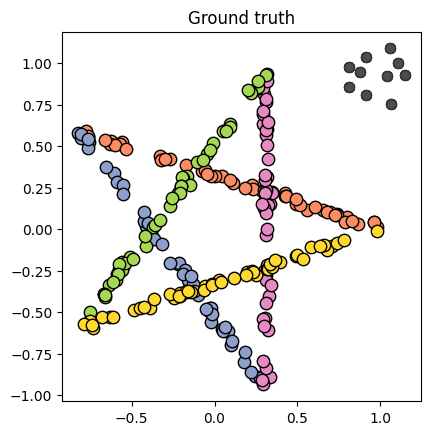

In [262]:
plt.figure(1)
display_clust(X,G, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

Implement the sequential ransac algorithm

In [263]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    model, inliers = simpleRANSAC(Y, epsi, cardmss)
    model = fit_line_dlt(Y[:, inliers])[0]

    if(len(inliers) < E_min):
        break
    
    currentModel.append(model)
    currentInliers.append(inliers)
    
    # remove current inliers
    Y = np.delete(Y, inliers, axis=1)

    # update iterations
    cnt += 1

Show the iteration of Sequential Ransac

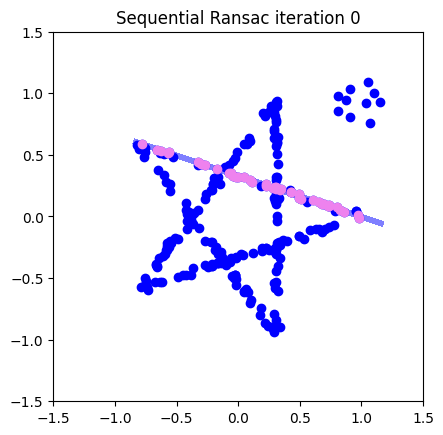

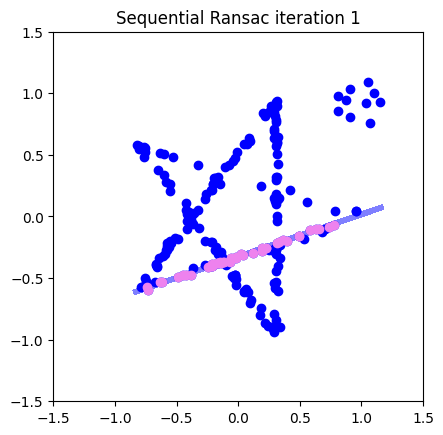

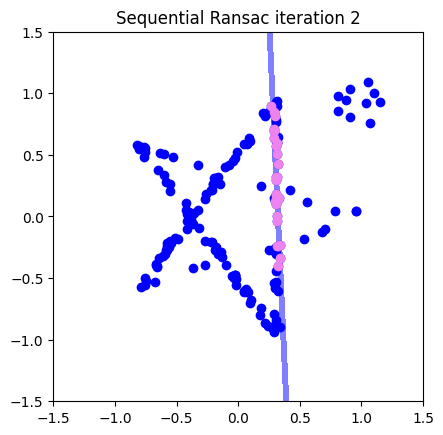

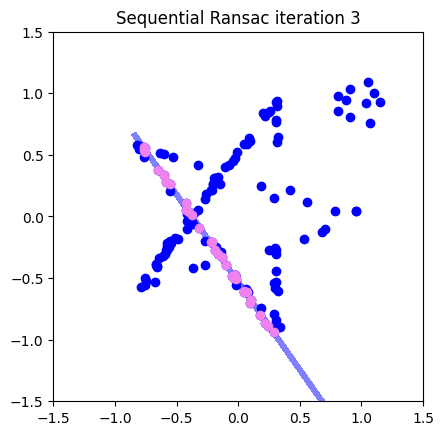

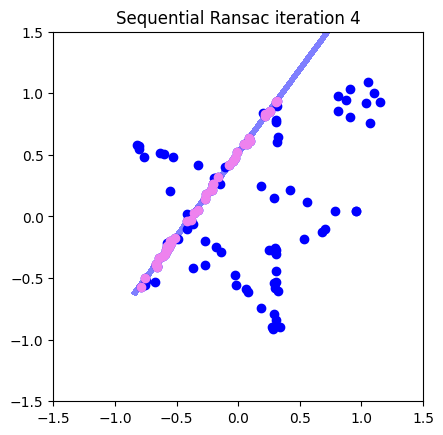

In [264]:
Y = X.copy()
plt.gca().set_aspect('equal')
for i in range(kappa):
    
    # display a band for each model estimated (see display_band function)
    display_band(Y, currentModel[i], epsi, col)
    
    # plot inliers for this model
    plt.scatter(Y[0, :], Y[1, :], c='blue')
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], c='violet')
    

    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)

    plt.title(f'Sequential Ransac iteration {i:d}')
    
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    
    plt.show()

MultiModel fitting on circle
----------------------------
Implement Ransac (thus run Sequential Ransac) to fit circles

In [265]:
epsi = 0.02 # inlier threshold for ransac


temp = loadmat(f'{rootfolder}/data/circle5.mat')

X = temp['X'] # data
G = temp['G'] # ground truth or label (1: normal, 0: outlier)

# model specification
# functions to fit and compute residuals are already invoked in the function
cardmss = 2          # minimum number of points required to fit a model
kappa = 5           # number of models to be extracted by sequential ransac

#  plotting params
bw = 0.01
col = 'b'
temp = loadmat(f'{rootfolder}/data/cmap.mat')
cmap = temp['cmap']

# add outliers
nOut = 10

# add outlier and update groundtruth
X = addOutliersInBB(X,nOut)

# update the label, considering that X previous command has appended nOut otliers 
G = np.vstack([G, np.zeros((nOut, 1))])


C:\Users\camil\AppData\Local\Temp\ipykernel_22476\2832099321.py:56: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x,y,80,cmap[i,:],marker=smb,edgecolors='k', alpha=1)
C:\Users\camil\AppData\Local\Temp\ipykernel_22476\2832099321.py:62: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X[0, id],X[1, id],50,[0.3,0.3,0.3],marker=smb,edgecolors=[0.2,0.2,0.2], alpha=1)


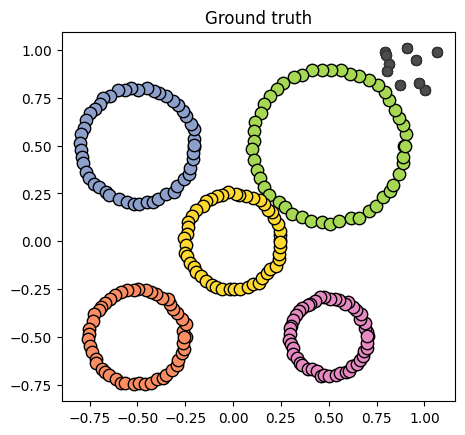

In [266]:
plt.figure(1)
display_clust(X,G, cmap)
plt.title('Ground truth')
plt.gca().set_aspect('equal')
plt.show()

**Idea**

$(x-x_0)^2+(y-y_0)^2 = r^2$

$2xx_0+2yy_0-x_0^2-y_0^2+r^2=x^2+y^2$

In [267]:
def res_circle(X, theta):
    a, b, r = theta
    X0 = X[0, :]
    Y0 = X[1, :]
    return np.abs(np.sqrt((X0 - a)**2 + (Y0 - b)**2) - r)

def fit_circle_ols(P):
    X = P.T[:, 0]
    Y = P.T[:, 1]
    
    # design matrix
    A = np.vstack([2*X, 2*Y, np.ones_like(X)]).T
    
    # vector of responses
    Y = X**2 + Y**2
    
    theta = np.linalg.pinv(A.T @ A) @ A.T @ Y
    
    residuals = np.abs(res_circle(P, theta))
    residual_error = np.sum(residuals ** 2)
    return theta, residuals, residual_error

def simpleRANSAC_circle(X, eps, cardmss = 2):
    """
    SIMPLERANSAC - Robust fit with the LMEDS algorithm
    X: matrix containing (x,y) coordinates of shape [num_features x num_samples]
    """
    # number of samples in the dataset
    n = X.shape[1] 
    # Desired probability of success
    alpha = 0.99 

    # Pessimistic estimate of inliers fraction
    f = 0.5

    # set maximum number of iterations
    MaxIterations = int(np.log(1 - alpha) / np.log(1-(1 - f)**cardmss))

    # set maximum consensus reached
    maxscore = - np.inf
    
    for i in range(MaxIterations):
        
        # Generate cardmss random indices in the range 0..n-1
        mss = X[:, np.random.choice(n, cardmss, replace=False)]
        
        # Fit model to this minimal sample set.
        theta = fit_circle_ols(mss)[0]

        # Evaluate distances between points and model
        sqres = res_circle(X, theta)

        # identify inliers: consensus set
        inliers = np.where(sqres < eps)[0]

        # assess consensus (the number of inliers)
        score = len(inliers)

        # replace maxscore, bestinliers and bestmodel if needed
        if score > maxscore:
            maxscore = score
            bestinliers = inliers
            bestmodel = theta

    return bestmodel, bestinliers

In [268]:
Y = X.copy() # take a copy of X to be modified

# define cells to contain the fitted models
currentModel = []
currentInliers = []

E_min = 10 # minimum number of expected inliers for each

cnt = 0
while cnt < kappa:
    # find model with ransac (save currentModel and currentInliers for visualization)
    model, inliers = simpleRANSAC_circle(Y, epsi, cardmss)
    model = fit_circle_ols(Y[:, inliers])[0]

    if(len(inliers) < E_min):
        break
    
    currentModel.append(model)
    currentInliers.append(inliers)
    
    # remove current inliers
    Y = np.delete(Y, inliers, axis=1)

    # update iterations
    cnt += 1

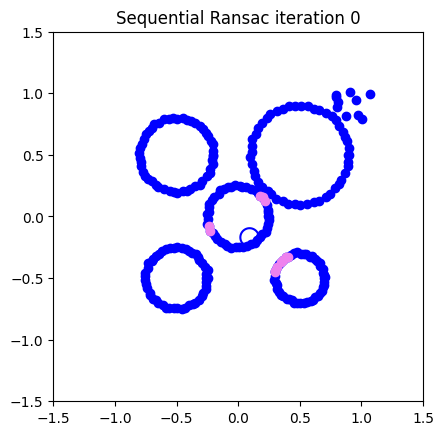

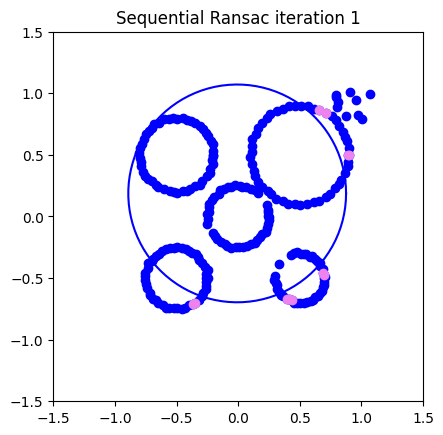

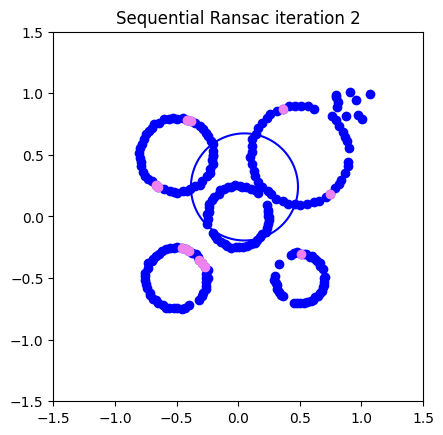

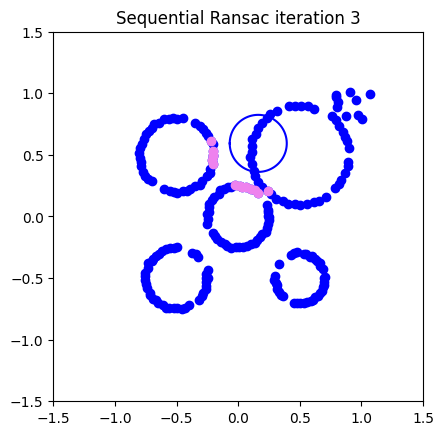

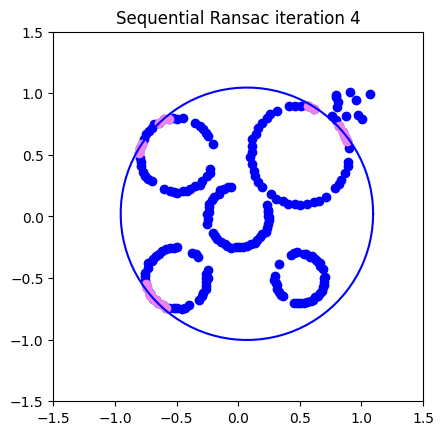

In [269]:
Y = X.copy()
plt.gca().set_aspect('equal')
for i in range(kappa):
    
    # display circle for each model estimated (see display_band function)
    plt.gca().set_aspect('equal')
    th = np.linspace(0, 2*np.pi, 100)
    x = currentModel[i][0] + currentModel[i][2] * np.cos(th)
    y = currentModel[i][1] + currentModel[i][2] * np.sin(th)
    plt.plot(x, y, c=col)
    
    # plot inliers for this model
    plt.scatter(Y[0, :], Y[1, :], c='blue')
    plt.scatter(Y[0, currentInliers[i]], Y[1, currentInliers[i]], c='violet')
    

    # you need to remove the inliers you have plot from Y, otherwise the indexes are wrong
    Y = np.delete(Y, currentInliers[i], axis=1)

    plt.title(f'Sequential Ransac iteration {i:d}')
    
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    
    plt.show()